In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import patsy

sns.set(style="whitegrid")

# Logistic Regression

In the last section, we looked at how we can use a linear model to fit a numerical target variable like child IQ (or price or height or weight). Regardless of the method you use, this is called a *regression problem*. Linear regression is one way of solving the regression problem.

When your target variable is a categorical variable, this is a *classification problem*. For now we'll work only with the case where there are two outcomes or labels.

With our numerical $y$, we started with a model:

$\hat{y} = N(\beta_0, \sigma)$

with the innovation that we could replace the mean in the normal distribution with a linear function of features, $f(X)$.

We can do the same thing for classification. If we have a binary categorical variable $y$, it has a Bernoulli distribution with probability $p$ as the parameter. We can estimate $y$ as:

$\hat{y} = p$

or the fraction of "successes" in the data. But what if we did the same thing as before? What if $p$ was a function of additional features? We would have:

$\hat{y} = \beta_0 + \beta_1 x$

and we would have a model that represented how the probability of $y$ changes as $x$ changes. Although this sounds good, there is a problem. $\beta_0 + \beta_1 x$ is not bounded to the range (0, 1) which we require for probabilities. But it does turn out that there is a solution: we can use a transformation to keep the value in the range (0, 1), the logistic function.

## The Logistic Function

The logistic function is:

$logistic(z) = logit^{-1}(z) = \frac{e^z}{1 + e^z} = \frac{1}{1 + e^{-z}}$

And it looks like the following:

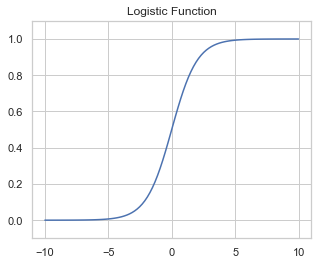

In [4]:
def logistic( z):
    return 1.0 / (1.0 + np.exp( -z))

figure = plt.figure(figsize=(5,4))

axes = figure.add_subplot(1, 1, 1)

xs = np.linspace( -10, 10, 100)
ys = logistic( xs)

axes.plot( xs, ys)
axes.set_ylim((-0.1, 1.1))
axes.set_title("Logistic Function")
plt.show()
plt.close()

No matter what the value of $x$, the value of $y$ is always between 0 and 1 which is exactly what we need for a probability.

There are a few additional things to note at this point. First, there is not a single definition of logistic regression. Gelman defines logistic regression as:

$P(y=1) = logit^{-1}(\beta_0 + \beta_1 x)$

in terms of the inverse logit function. Such a function returns the probability that $y = 1$. There are other possibilites (for example, a general maximum entropy model).

Second, interpreting the coefficients becomes a bit of a problem. Let's assume that we have no features and only have:

$P(y=1) = logit^{-1}(\beta_0)$

what, exactly, is $\beta_0$? It's not a probability because the probability interpretation only takes place once we have transformed the result using the inverse logit function. We take note of the following truism:

$logit^{-1}( logit( p)) = p$

This is simply what it means to be an inverse function of some other function. But the interesting thing is that this means that:

$\beta_0 = logit( p)$

and we do know what $logit(p)$ is, it's the *log odds*. $logit$ is defined as:

$logit(p) = log(\frac{p}{1-p})$

if $p$ is the probability of an event, then $\frac{p}{1-p}$ is the log odds of the event (the ratio of the probability for an event and the probability against the event).

The third difficulty is that the logistic regression is non-linear. For linear regression, the slopes of the curve (a line) are constant (the $\beta$s) and while logistic regression has a linear predictor, the result is non-linear in the probability space. For example, a 0.4 point increase in log odds from 0.0 to 0.4 increases probability from 50% to 60% but a 0.4 point increase in log odds from 2.2 to 2.6 only increases probability from 90% to 93%.

Finally, we lose a lot of our ability to visualize what's going on when we moved from linear regression to logistic regression.

## Logistic Regression with Continuous Feature (Synthetic Data)

As before, we're going to start with synthetic data to get our proverbial feet wet. Even here, generating synthetic data isn't as easy as it is for linear regression. We basically need to estimate the $p$ for each value of $x$ and then simulate it. The algorithm is something like this:

```
1. generate x using the standard normal distribution or binomial if categorical.
2. for each data point:
3.     z = beta_0 + beta_1 * x
4.     pr = 1/(1_exp(-z))
5.     y = 1 if rand() < pr else 0
```

Of note, the logistic function does not output $\hat{y}$ as it does with linear regression. It outputs the estimated probability of $y=1$. We can take that probability and compare it to a threshold and assign $y = 0$ or $y = 1$. The $y$ above is the *real* y for the synthetic data.

In [5]:
np.random.seed(83474722)

In [6]:
data = {}
data["x"] = stats.norm.rvs(0, 1, 100)
data["z"] = 0.5 + data["x"] * 0.5
data["pr"] = list(map(lambda z: logistic(z), data["z"]))
data["y"] = list(map(lambda pr: 1 if np.random.uniform() < pr else 0, data["pr"]))
data = pd.DataFrame(data)

It's worth taking a bit more in-depth look at this data even though it's synthetic (or *because* it's synthetic). We generated $x$ from the standard Normal distribution: $x \sim N(0, 1)$. $z$, an intermediate step, is the actual linear model: $z = \beta_0 + \beta_1 x$ or $z = 0.5 + 0.5 x$.

As the earlier discussion mentions, we pass $z$ through the logistic function to bound it to the interval (0, 1). The result, $pr$, represents a probability. This is a conditional probability: $P(y=1|x)$. In order to find out the "true" $y$ for each $x$, we simulate that probability. 

As we can see in the table below, we have $pr=0.663$ and $y=1$ (obs 1) as well as $pr=0.857$ and $y=0$. This is logistic regression's form of "error", "noise", or the "known unknowns and unknown unknowns".

In [7]:
data.head()

,x,z,pr,y
0,0.355745,0.677873,0.663264,1
1,0.412298,0.706149,0.669550,1
2,-0.830253,0.084874,0.521206,1
3,2.579133,1.789567,0.856874,0
4,-1.067772,-0.033886,0.491529,0


We could use a constant model as we have before:

In [8]:
np.mean(data.y)

0.57

No matter what $x$ is, we say there's a 57% probability that the value of $y$ is 1. Since 57% is over 50%, we could just guess that for any $x$, $\hat{y} = 1$. We would be right 57 of the time and wrong 43% of the time on average. 43% is the model's *error rate*.

Can we do better?

In [9]:
import sys
sys.path.append('../resources')
import fundamentals.models as models

In [10]:
result = models.logistic_regression("y ~ x", data = data)

In [11]:
models.simple_describe_lgr(result)

We do a *little* better. The error rate here is 42% instead of (1-0.57) or 43% but that's not very encouraging. Logistic Regression doesn't actually *have* an $R^2$ metric. What we have shown here is Efron's Pseudo $R^2$. It basically measures the same thing as interpretation #1 of the "real" $R^2$: it's the percent of the variability in $y$ explained by the model. Not very much.

Additionally, our estimates of the coefficients, $\beta_0$ and $\beta_1$, are pretty bad compared to the ground truth in the synthetic data. In the linear regression case we were able to recover them fairly easily. Why is the synthetic data so bad?

Note that our base probability is not really much different than a coin toss (57% versus 50%). Assume a given $x$ leads to a probability of 65%. We need a lot more examples of $x$ to calculate that 65%...if we only have a few, we may never actually observe the case where $y=1$.

What happens with the current data generator if we just generate more data, n=10,000 instead of n=100?

In [12]:
data = {}
data["x"] = stats.norm.rvs(0, 1, 10000)
data["z"] = 0.5 + data["x"] * 0.5
data["pr"] = list(map(lambda z: logistic(z), data["z"]))
data["y"] = list(map(lambda pr: 1 if np.random.uniform() < pr else 0, data["pr"]))
data = pd.DataFrame(data)

We can re-run our logistic regression on this data:

In [13]:
result1 = models.logistic_regression("y ~ x", data = data)
models.simple_describe_lgr(result1)

Our coefficient estimates are almost exactly the same as the ground truth. Still our error rate is 36.3% instead of 43.0%. This is probably as good as we can get. What happens if bump up the base probability a bit?

In [14]:
data = {}
data["x"] = stats.norm.rvs(0, 1, 10000)
data["z"] = 0.75 + data["x"] * 10
data["pr"] = list(map(lambda z: logistic(z), data["z"]))
data["y"] = list(map(lambda pr: 1 if np.random.uniform() < pr else 0, data["pr"]))
data = pd.DataFrame(data)

Let's look at this data. The probabilities of each observation are now either very near 0 or very near 1:

In [15]:
data.head()

,x,z,pr,y
0,0.875917,9.509174,0.999926,1
1,-0.537053,-4.620530,0.009752,0
2,0.809259,8.842593,0.999856,1
3,-0.632188,-5.571878,0.003789,0
4,-0.757485,-6.824855,0.001085,0


The constant model shows a probability of 52.2% for $y=1$. This means it has an error rate of 47.8%!

In [16]:
np.mean(data.y)

0.5215

What about our logistic regression model?

In [17]:
result2 = models.logistic_regression("y ~ x", data = data)
models.simple_describe_lgr(result2)

The coefficients are almost exact *and* the error rate is only 5.1%. The (pseudo) $R^2$ shows that our model explains 85% of the variation in $y$.

This set of experiments shows us a number of things. First, generating synthetic data is very useful for learning how your algorithms work. In fact, let's do one more experiment. Let's reduce the number of observations back to 100:

In [18]:
data = {}
data["x"] = stats.norm.rvs(0, 1, 10000)
data["z"] = 0.75 + data["x"] * 10
data["pr"] = list(map(lambda z: logistic(z), data["z"]))
data["y"] = list(map(lambda pr: 1 if np.random.uniform() < pr else 0, data["pr"]))
data = pd.DataFrame(data)

In [19]:
result3 = models.logistic_regression("y ~ x", data = data)
models.simple_describe_lgr(result3)

Here our error rate is still quite a bit lower but the estimates of our coefficients aren't as good. We need both a lot of data and clear underlying pattern *and* this pattern isn't as obvious as it is with linear regression.

## Logistic Regression with Real Data

When it comes to either numerical features or a binary categorical features, there is no difference between linear regression and logistic regression. We can have numerical features which will affect the slope and intercept of the line. We can have binary categorical features that will affect the intercept of the line. We can have interaction terms that will affect the slope of the line.

The main difference with linear regression is in the interpretation of the coefficients.

For logistic regression, the coefficients are log-odds and while some people are quite comfortable thinking in terms of log-odds, most are not. How do we convert them into something we can understand?

Let's begin the discussion by looking at real data. This data is from a study of villager behavior in Bangladesh. Wells were examined for natural arsenic contamination and villagers using wells with higher arsenic readings were encouraged to use other wells or dig new ones. The variables are:

* **switch** - yes (1) or no (0), did the respondent switch to a new well.
* **dist** - distance to the nearest safe well in meters.
* **arsenic** - arsenic level of the respondent’s well.
* **assoc** - does the respondent or a family member belong to a community association.
* **educ** - the educational attainment of the respondent in years.

Let's start out with a logistic regression model for $\hat{switch}$:

$P(\hat{switch}=1) = logistic^{-1}(\beta_0 + \beta_1 dist)$

although we really have something like:

$z = \beta_0 + \beta_1 dist$

$\hat{pr} = \frac{1}{1+e^{-z}}$

$\hat{y}$ = 1 if $\hat{pr}$ > 0.5 else 0

which is a bit more complicated to write each time.

In [20]:
wells = pd.read_csv( "../resources/data/arsenic.wells.tsv", sep=" ")

Let's check the representations:

In [21]:
wells.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3020 entries, 1 to 3020
Data columns (total 5 columns):
switch     3020 non-null int64
arsenic    3020 non-null float64
dist       3020 non-null float64
assoc      3020 non-null int64
educ       3020 non-null int64
dtypes: float64(2), int64(3)
memory usage: 141.6 KB


There is nothing particularly startling here. Let's see a few values:

In [22]:
wells.head()

,switch,arsenic,dist,assoc,educ
1,1,2.36,16.826000,0,0
2,1,0.71,47.321999,0,0
3,0,2.07,20.966999,0,10
4,1,1.15,21.486000,0,12
5,1,1.10,40.874001,1,14


The base model (and error rate) are:

In [23]:
mean = np.mean(wells.switch)
print("P(switch=1) = {0:.2f} ({1:.2f})".format(mean, 1-mean))

P(switch=1) = 0.58 (0.42)


The base model (often called the "null" model) is that $P(switch=1) = 0.58$ which leads to an error rate of 42%. Let's see what logistic regression can get us:

In [24]:
result = models.logistic_regression( "switch ~ dist", data = wells)
models.simple_describe_lgr(result)

So again, this is the real world and real data and sometimes you only get improvements such as these. Despite the showing on this data, logistic regression is a very powerful modeling technique.

We can see that the error rate and (pseudo) $R^2$ of this model aren't great but we're much more interested in interpreting the model coefficients. What do they mean?

### Intercept

The intercept in this case has a legitimate $dist = 0$ interpretation. If the alternative well is 0 meters away, what is the probability of switching?

We can use our previous identity and use the inverse logit (logistic) function:

In [25]:
logistic( 0.6038)

0.6465252043640823

so the probability of switching is 64.7% if the safe well is zero meters away (that doesn't really bode well). If we were to run the logistic regression without any regressors, we could think of $\beta_0$ as the *prior* log odds. In essence, logistic regression is a function that calculates conditional probabilities based on the features instead of using a table. 

Once you add features, $\beta_0$ is no longer a pure prior because it has been optimized in the presence of the other features and therefore is still a conditional probability...just with all the features at 0.

### Coefficients

Next, we can look at each coefficient (or in this case, the only coefficient). The model basically says there is a 0.0062 decrease in *log odds* (remember that the coefficients are not in probability space until transformed) for every meter to the nearest safe well. Now we have a problem. While $\beta_i$ as *log odds* is linear in $x_i$ (that's *all* the term "linear model" means), arbitrary transformations of $\beta_i$, $t(\beta_i)$ is not necessarily linear in $x_i$ and that is the case here. How do we get around this problem? 


There are several options:

**No. 1 - Evaluate at the mean of the variable with a unit change.**

The mean value of dist(ance) is 48.33. If we evaluate our model using that value, we get:

$P(switch = 1)$ = $logit^{-1}(0.6038 - 0.0062 \times 48.33)$ = $logit^{-1}(0.304154)$ = 0.5755

And if we do the same thing again after adding 1 meter to the average distance, we get:

$P(switch = 1)$ = $logit^{-1}(0.6038 - 0.0062 \times 49.33)$ = $logit^{-1}(0.297954)$ = 0.5739

So...that's a decrease of about 0.0016 percentage points (or 0.27%) which isn't huge but then we only increased the difference by a little over 3 feet!

But, you need to be careful with mean scaled data (which we'll talk about in the next chapter). A unit change is equal to one entire standard deviation which may be an extremely large value...or an extremely small one.

In [26]:
a = logistic( 0.6038 - 0.0062 * 48.33)
b = logistic( 0.6038 - 0.0062 * 49.33)
print(a, b)
print(a - b)

0.5754576812550608 0.5739422790895422
0.0015154021655185979


If you have more than one $x_i$, you should set all of them to their mean values and then do a unit change for each variable separately.

Note that this is a good reason to mean *center* data in a logistic regression but not to mean *scale* it. The reason for not mean scaling is that:

1. The coefficients do have clear interpretations and relative magnitudes (changes in probability after transformation).
2. Mean *scaling* makes 1 unit equal to one standard deviation of the standard normal distribution. This might be a very, very large value in the variables actual domain which messes up the approximation.

**No. 2 - Calculate the derivative of the logistic and evaluate it at the mean of the variable.**

$\frac{\partial}{\partial x_i}logit^{-1}(\beta X) = \frac{\beta_i e^{\beta X}}{(1 + e^{\beta X})^2}$

but $\beta X$ (z) is just the log odds at the mean values of X (if X is indeed $[1.0, \bar{x}_1, \bar{x}_2, ... ,\bar{x}_n]$) so if we plug our value for the model evaluated at the mean into the derivative, we get:

$\frac{0.0062 e^{0.0062 \times 0.3042}}{(1 + e^{0.0062 \times 0.3042})^2} = 0.0016$

In [27]:
def logistic_slope_at( beta, z):
    return (beta * np.exp( beta * z)) / (1.0 + np.exp( beta * z))**2

print(logistic_slope_at( 0.0062, 0.3042))

0.0015499986216064004


**No. 3 - Divide by 4 Rule**

$\beta_1 / 4 = 0.0062 / 4 = 0.00155$

It's just a rule of thumb but easy. It has the same general interpretation though...the change in probability from a unit change at the mean of the regressor. Again, this approach can get very funky with mean scaled data because a unit change is a full standard deviation which can actually be enormous or infinitesimal. Why does that work?

The slope of the logistic curve is maximized where the first derivative is zero or $\beta_0 + \beta_1 + x = 0$. We can solve for this as:


$\frac{beta_1e^0}{(1+e^0)^2}$

$\frac{\beta_1 \times 1}{(1+1)^2}$

$\frac{\beta_1}{4}$

This interpretation holds best in the context of mean values for the corresponding feature, $x$.

**No. 4 - Average Predictive Difference**

We can also average the probabilities over all of our data points for a specific change in each of our predictors. For a model with only one predictor, this amounts to the same thing as No. 1 so we will save this for later.

## Useful Transformations

We'll talk more about transformations in the next chapter. The main point of this chapter is to establish what linear and logistic regression are and how to interpret them. However, there is an especially useful transformation for logistic regression and that involves transforming the units.

This doesn't affect the quality of the model at all. It does, however, change how you interpret it. For example, the current units of $dist$ are meters. The probability of change per *meter* is pretty small. But what about the probability of changing per *ten meters*? That's nearly 33 feet.

In [28]:
wells["dist10"] = wells["dist"]/10

In [29]:
result = models.logistic_regression( "switch ~ dist10", data = wells)
models.simple_describe_lgr(result)

We can now reinterpret the model. The probability of switching decreases by 1.5% (-00.619/4 = -0.015475 or "Divide by 4" rule) at the average when the distance to the safe well increases by 10 meters.

It's interesting to note that Gelman used 100 to scale his data. The problem with this, in an interpetability sense, is that if you look at distance, the median distance to a safe well is 36.7 meters. The 3rd quartile is 64 meters. A 100 meter difference just doesn't figure prominently into the data even though the maximum distance was 339.5 meters. 10 meters seems like a reasonable unit in this case.

Again, this doesn't change how good the model is. But it does it easier to talk about than "15 100ths of a percent per meter".

## Plotting Logistic Regression

It's not quite as easy to plot a logistic regression as it is linear regression. If we just plot the data, we have:

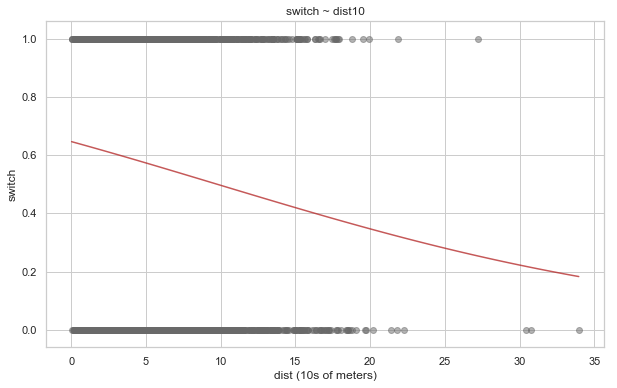

In [30]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

xs = wells[ "dist10"]
ys = wells[ "switch"]
axes.scatter( xs, ys, color="dimgray", alpha=0.5)
betas = result[ "coefficients"]

zs = np.linspace( xs.min(), xs.max(), 100)
ps = [logistic( betas[ 0] + betas[ 1] * x) for x in zs]

axes.plot(zs, ps, '-', color="firebrick", alpha=0.75)
axes.set_title( result[ "formula"])
axes.set_xlabel("dist (10s of meters)")
axes.set_ylabel("switch")

plt.show()
plt.close()

It's just not very interesting or informative on its own. Additionally, you have the problem that logistic regression is nonlinear. We'll get into plotting multivariate regression (linear and logistic) in the next chapter. The solution for logistic regression is usually to plot the *decision boundary* in feature space and not to plot the target at all.

## Bootstrap Inference

As with linear regression, we can also apply bootstrap inference to logistic regression and with the same results. Here we only show the function in operation. We also make the innovation that we include "divide by 4" interpretations of our coefficients:

In [31]:
result = models.bootstrap_logistic_regression("switch ~ dist10", wells)
models.describe_bootstrap_lgr(result, 3)

The development so far has been pedagogical. You should always do bootstrap inference for both linear and logistic regression and going forward, we will.